### SAでのテンプレートを更新
バッチサイズ分だけ並行して実施する

In [1]:
import os
# 環境によって変更
os.chdir('/home/jovyan/work/notebook')

In [2]:
CFG = {
    "base_ex_num": "014",  # ベースとしている実験ノートブック
    "qid": 0,  # 問題番号(0~5)
    "path": "../model",  # モデルのパス(git管理外なので実行環境で変更)
    # path = "../../output"    
    "restart": True,  # True: 途中から再開, False: sampleを使って最初から開始
    "restart_file_path": "../model/out/current_texts_014_0.csv",  # 途中から再開する場合のファイルパス
    "start_temperature": 40,  # 初期温度
    "end_temperature": 10,  # 終了温度
    "cooling_rate": 0.9,  # 温度の下がり具合
    "cooling_span": 10,  # 何iterationごとに温度を下げるか
    "iteration": int(1e3),  # iteration数
    "batch_size": 8,  # バッチサイズ(並行して計算する数)
    "save_interval": 10,  # 何回のiterationごとにlog保存するか
    "split_rule": "default",  # 文章を単語に分割する方法(default(スペース区切り), compress(連続単語はくっつける))
    "neighbor_types": ["swap", "insert", "segment_insert"],  # 近傍操作の種類
    "seed": 42,  # seed値
}

In [3]:
import wandb

wandb.login()

wandb.init(
    # プロジェクト名
    project="santa2024",

    # 記録する実験条件
    config=CFG
)

git root error: Cmd('git') failed due to: exit code(128)
  cmdline: git rev-parse --show-toplevel
  stderr: 'fatal: detected dubious ownership in repository at '/home/jovyan/work'
To add an exception for this directory, call:

	git config --global --add safe.directory /home/jovyan/work'
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: shun2741 (shun2741-ns-solutions). Use `wandb login --relogin` to force relogin


In [4]:
import numpy as np
import pandas as pd
import os
import time
import csv

from tqdm.notebook import tqdm

import random
from typing import List, Callable
import itertools, math
from typing import List, Tuple

from utils import PerplexityCalculator
# 可視化用
import matplotlib.pyplot as plt

In [5]:
# seed値の固定
# Pythonの組み込みrandomモジュールのシードを設定
random.seed(CFG["seed"])

# NumPyのシードを設定
np.random.seed(CFG["seed"])

### データ読み込み

In [6]:
if CFG["restart"]:
    df = pd.read_csv(CFG["restart_file_path"])
    display(df)
    
    if len(df) != CFG["batch_size"]:
        AssertionError("batch_sizeが再開前のサイズと一致しません")   
else:
    df = pd.read_csv("../input/sample_submission.csv")
    display(df)

,index,text,score
0,0,gingerbread ornament elf family advent scrooge...,1067.053350
1,1,scrooge mistletoe family gingerbread elf adven...,1026.175178
2,2,reindeer mistletoe elf gingerbread scrooge orn...,600.905389
3,3,ornament scrooge mistletoe gingerbread chimney...,1223.382693
4,4,ornament scrooge reindeer mistletoe family adv...,1181.120390
5,5,reindeer mistletoe gingerbread chimney elf adv...,619.980174
6,6,scrooge mistletoe reindeer elf family advent o...,1153.759766
7,7,reindeer mistletoe elf gingerbread family fire...,612.757186


### 関数

In [7]:
def split_compress(sentence: str) -> list[str]:
    """
    文章をスペースで分割し、連続している単語を結合する
    同一の単語が連続している場合は１つの塊として処理する
    args:
        sentence: str: 分割する文章
    return:
        list[str]: 分割された単語のリスト
    """
    words = sentence.split()
    
    if CFG["split_rule"] != "compress":
        return words
    if not words:
        return []

    result = []
    prev_word = None

    for w in words:
        if w == prev_word:
            # 連続している場合は、リストの最後の要素にスペースを挟んで追加
            result[-1] += " " + w
        else:
            # 新しい単語の場合はリストに追加
            result.append(w)
        prev_word = w

    return result

In [8]:
def plot_score_and_temperature(scores_history, temp_history):
    """
    スコアと温度の推移をプロットする

    args:
        scores_history: List[float]: スコアの推移
        temp_history: List[float]: 温度の推移
    return:
        None
    """
    # x 軸: イテレーション
    x = range(len(scores_history))
    
    # Figure と Axes を作成
    fig, ax1 = plt.subplots(figsize=(8,5))
    
    # スコア用の軸 (左)
    color_score = 'tab:blue'
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Score (Perplexity)', color=color_score)
    ax1.plot(x, scores_history, label='Score', color=color_score)
    ax1.tick_params(axis='y', labelcolor=color_score)
    
    # 温度用の軸 (右) : twinx で第二のY軸を作成
    ax2 = ax1.twinx()
    color_temp = 'tab:red'
    ax2.set_ylabel('Temperature', color=color_temp)
    ax2.plot(x, temp_history, label='Temperature', color=color_temp)
    ax2.tick_params(axis='y', labelcolor=color_temp)
    
    # タイトル等
    plt.title('Score & Temperature Transition')
    fig.tight_layout()
    plt.show()

In [9]:
def generate_neighbor(sequence, neighbor_type='swap'):
    """
    近傍操作を行う
    
    args:
        sequence: List[str]: 単語のリスト
        neighbor_type: str: 近傍操作の種類
    return:
        List[str]: 近傍操作後の単語のリスト
    """
    new_seq = sequence[:]
    length = len(new_seq)

    if neighbor_type == 'swap':
        # ランダムに2つの位置を選んで入れ替える
        a, b = random.sample(range(length), 2)
        new_seq[a], new_seq[b] = new_seq[b], new_seq[a]

    elif neighbor_type == 'insert':
        # ある単語を抜き出し、別の位置に挿入する
        idx = random.randint(0, length - 1)
        word = new_seq.pop(idx)
        new_pos = random.randint(0, length - 1)
        new_seq.insert(new_pos, word)

    elif neighbor_type == 'segment_insert':
        # 長さ2~5のランダムな部分区間を切り出して、別の位置に挿入
        # 部分区間の長さをランダムに選択（2～5）
        sublist_length = random.randint(2, 5)

        # 部分区間の開始位置をランダムに選択
        start_idx = random.randint(0, length - sublist_length)

        # 部分区間を切り出し
        sublist = new_seq[start_idx:start_idx + sublist_length]

        # 部分区間を元のリストから削除
        new_seq = new_seq[:start_idx] +new_seq[start_idx + sublist_length:]

        # 挿入位置をランダムに選択（元の部分区間の位置は除く）
        insert_idx = random.randint(0, len(new_seq))

        # 切り出した部分区間を挿入
        new_seq = new_seq[:insert_idx] + sublist + new_seq[insert_idx:]

    # 他にも様々な近傍操作を追加可能

    return new_seq

In [10]:
def search_annealing(
    scorer,
    initial_sequences,
):
    """
    焼きなまし法による探索

    args:
        scorer: PerplexityCalculator: 評価器
        initial_sequences: List[List[str]]: 初期解のリスト
    """
    if CFG["neighbor_types"] is None:
        neighbor_types = ['swap']

    texts = [" ".join(seq) for seq in initial_sequences]
    scores = scorer.get_perplexity(texts, batch_size=CFG["batch_size"])

    # スコア推移を記録するリスト
    scores_history = []
    temp_history = []
    
    # 現在の状態を持つリスト
    current_seqs = []
    current_scores = []
    
    # 初期解の生成
    for i in range(CFG["batch_size"]):
        print("current_seq:", initial_sequences[i])
        print("current_score:", scores[i])
        current_seqs.append(initial_sequences[i])
        current_scores.append(scores[i])
    
    idx = np.argmin(current_scores)
    best_score = current_scores[idx]
    best_seq = current_seqs[idx]
    print("best_score:", best_score)
    print("best_text:", " ".join(best_seq))
    
    # 初期温度        
    temperature = CFG["start_temperature"]
    
    for itr in tqdm(range(CFG["iteration"])):
        # 可視化用の記録
        scores_history.append(current_scores[0])
        temp_history.append(temperature)
        
        # 近傍候補をまとめて生成
        neighbor_candidates = []
        for i in range(CFG["batch_size"]):
            # 近傍操作の種類をランダムに選ぶ
            n_type = random.choice(CFG["neighbor_types"])
            neighbor_seq = generate_neighbor(current_seqs[i], n_type)
            neighbor_candidates.append(neighbor_seq)

        
        # まとめてスコアを計算（GPUを活用）
        texts = [" ".join(seq) for seq in neighbor_candidates]
        # print("texts:", texts)
        
        scores = scorer.get_perplexity(texts, batch_size=CFG["batch_size"])
        # print("scores:", scores)
        
        # 候補の中から1つを焼きなまし法の確率的受容ルールで選ぶ
        for i, (cand_seq, cand_score) in enumerate(zip(neighbor_candidates, scores)):
            delta = cand_score - current_scores[i]
            accept_prob = math.exp(-delta / temperature) if delta > 0 else 1.0
                
            # スコアが良ければ必ず受容
            if random.random() < accept_prob:
                current_scores[i] = cand_score
                current_seqs[i] = cand_seq

        # ベストの更新
        if np.min(current_scores) < best_score:
            # current_scoresの最小値のインデックスを取得
            idx = np.argmin(current_scores)
            
            best_score = current_scores[idx]
            best_seq = current_seqs[idx]
            print(f"iter {itr}: best_score: {best_score}")
            print("best_text:", " ".join(best_seq))
            

        # 温度を下げる
        if itr % CFG["cooling_span"] == 0:
            temperature *= CFG["cooling_rate"]
            wandb.log({"temperature": temperature, "score":current_scores[0]})
        
        if itr % CFG["save_interval"] == 0:
            print(f"iter :{itr}, best_score: {best_score}, temperature: {temperature}")
            wandb.log({"iteration": itr, "best_score": best_score, "best_text": " ".join(best_seq)})

            # current_seqsを結合して文字列保存
            current_seqs_text = [" ".join(seq) for seq in current_seqs]
            # current_seqsとcurrent_scoresのリストをdfとして保存
            df = pd.DataFrame(current_seqs_text)
            df["score"] = current_scores
            
            # indexとなっていたものをsequencre列に変更
            df = df.reset_index()
            df = df.rename(columns={0: "text"})
            
            path = CFG["path"]
            ex_num = CFG["base_ex_num"]
            qid = CFG["qid"]
            df.to_csv(f"{path}/out/current_texts_{ex_num}_{qid}.csv", index=False)
            
        if temperature < CFG["end_temperature"]:
            break
    
    # 現在のラン名を取得
    current_run_name = wandb.run.name
    print(f"Current Run Name: {current_run_name}")
    
    # artifactに保存
    artifact = wandb.Artifact(name=current_run_name, type="texts")
    path = CFG["path"]
    ex_num = CFG["base_ex_num"]
    qid = CFG["qid"]
    artifact.add_file(local_path =f"{path}/out/current_texts_{ex_num}_{qid}.csv", name =f"current_texts_{ex_num}_{qid}.csv")
    artifact.save()
        
    return best_seq, best_score, scores_history, temp_history

In [11]:
def search_optimal_permutation(
    scorer
):

    if CFG["restart"]:
        df = pd.read_csv(CFG["restart_file_path"])
        
        # dfのsequence列をリストに変換
        initial_texts = df["text"].tolist()
        # initial_sequencesをスペースで区切ってリストに変換
        initial_sequences = [split_compress(text) for text in initial_texts]
    
    else:
        df = pd.read_csv("../input/sample_submission.csv")    
        qid = CFG["qid"]
        original_text = df.iloc[qid]["text"]
        original_seq = split_compress(original_text)
        initial_sequences = [random.sample(original_seq, len(original_seq)) for _ in range(CFG["batch_size"])]
    
    start = time.time()
    print("---------焼きなまし処理開始---------")
    best_sequence, best_score, scores_history, temp_history = search_annealing(
        scorer=scorer,
        initial_sequences=initial_sequences,
    )
    print("---------焼きなまし処理終了---------")
    
    print(f"{id}th sample: {" ".join(best_sequence)}")
    print(f"Elapsed time: {time.time() - start:.2f} sec")
    print(f"best_score: {best_score}")
    
    plot_score_and_temperature(scores_history, temp_history)
    
    return best_sequence, best_score


In [12]:
# LOAD GEMMA SCORER
scorer = PerplexityCalculator(f'{CFG["path"]}/gemma_2_9b')

cuda


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


In [13]:
# scorer.clear_gpu_memory()

Processing
---------焼きなまし処理開始---------
current_seq: ['gingerbread', 'ornament', 'elf', 'family', 'advent', 'scrooge', 'reindeer', 'mistletoe', 'fireplace', 'chimney']
current_score: 1067.053349944732
current_seq: ['scrooge', 'mistletoe', 'family', 'gingerbread', 'elf', 'advent', 'chimney', 'reindeer', 'ornament', 'fireplace']
current_score: 1026.1751780534337
current_seq: ['reindeer', 'mistletoe', 'elf', 'gingerbread', 'scrooge', 'ornament', 'family', 'advent', 'fireplace', 'chimney']
current_score: 600.905389292032
current_seq: ['ornament', 'scrooge', 'mistletoe', 'gingerbread', 'chimney', 'family', 'advent', 'fireplace', 'elf', 'reindeer']
current_score: 1223.3826929169447
current_seq: ['ornament', 'scrooge', 'reindeer', 'mistletoe', 'family', 'advent', 'elf', 'gingerbread', 'chimney', 'fireplace']
current_score: 1181.120389956714
current_seq: ['reindeer', 'mistletoe', 'gingerbread', 'chimney', 'elf', 'advent', 'scrooge', 'family', 'ornament', 'fireplace']
current_score: 619.98017393

  0%|          | 0/1000 [00:00<?, ?it/s]

iter :0, best_score: 600.905389292032, temperature: 36.0
iter 5: best_score: 598.5626811957673
best_text: reindeer mistletoe gingerbread chimney elf advent scrooge family fireplace ornament
iter :10, best_score: 598.5626811957673, temperature: 32.4
iter 14: best_score: 532.3726691377844
best_text: reindeer mistletoe elf scrooge gingerbread ornament family advent chimney fireplace
iter :20, best_score: 532.3726691377844, temperature: 29.16
iter :30, best_score: 532.3726691377844, temperature: 26.244
iter :40, best_score: 532.3726691377844, temperature: 23.619600000000002
iter :50, best_score: 532.3726691377844, temperature: 21.257640000000002
iter :60, best_score: 532.3726691377844, temperature: 19.131876000000002
iter 63: best_score: 530.2971447966088
best_text: reindeer mistletoe elf scrooge gingerbread family ornament advent chimney fireplace
iter :70, best_score: 530.2971447966088, temperature: 17.2186884
iter 73: best_score: 513.9816168847873
best_text: reindeer mistletoe gingerbre

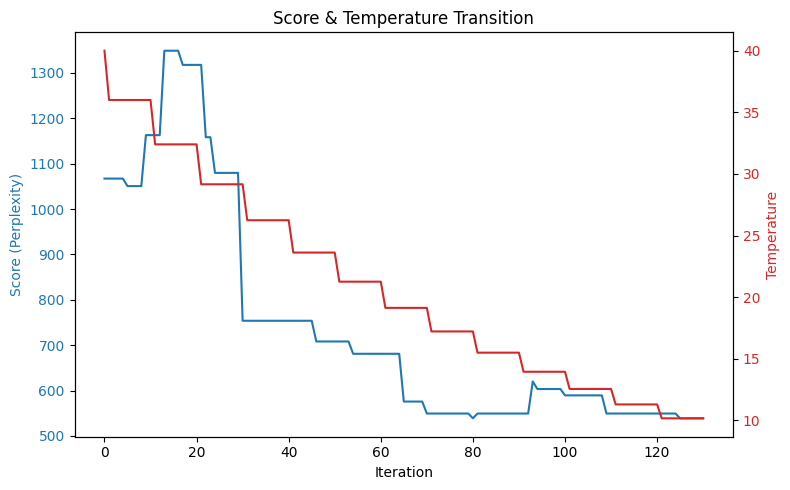

Best text: reindeer mistletoe gingerbread elf family advent scrooge chimney fireplace ornament
Best score: 513.9816168847873


In [14]:
print(f"Processing")
best_sequence, best_score = search_optimal_permutation(
    scorer=scorer,
)

print("Best text:", " ".join(best_sequence))
print("Best score:", best_score)
